## ベースラインの作成

初学者がとっかかりやすくするように、  
公開ベースラインを作成する。


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import re
import tqdm
# import plotly.express as ex
import sklearn
# import pandas_profiling as pdp
import datetime
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
import warnings
from itertools import cycle
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,auc,log_loss,roc_curve,roc_auc_score
import datetime
from sklearn.preprocessing import LabelEncoder

In [2]:
warnings.filterwarnings("ignore")
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])


In [12]:
train_path = 'train.csv'
test_path = 'test_w_ans.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

df = pd.concat([train_df,test_df])
print(train_df.shape,test_df.shape)

df['arrival_date'] = pd.to_datetime(df['arrival_date'])


(108785, 26) (10099, 26)


In [16]:
num_features = ["lead_time",
                "stays_in_weekend_nights","stays_in_week_nights","adults","children",
                "babies","is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled","agent","company",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]

cat_features = ["hotel","meal","market_segment",
                "distribution_channel","reserved_room_type","customer_type"]

features = num_features + cat_features

In [17]:
le = LabelEncoder()
le_dict = {}
for col in cat_features:
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])
    le_dict['col']=le
    
train_df[cat_features] = train_df[cat_features].astype('category')
test_df[cat_features] = test_df[cat_features].astype('category')

In [18]:
train_X = train_df.drop(["is_canceled",'arrival_date'], axis=1)[features]
train_y = train_df["is_canceled"]

test_X = test_df.drop(["is_canceled",'arrival_date'], axis=1)[features]
test_y = test_df["is_canceled"]

In [19]:
train_X_arr = train_X.values
test_X_arr = test_X.values

In [ ]:
clf = RandomForestClassifier()

In [35]:
kfolds = 4 # 4 = 75% train, 25% validation
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)
preds =np.zeros((len(test_X_arr),))

FIs = np.zeros(train_X_arr.shape[1])
for i,(train_idx, val_idx) in enumerate(split.split(train_X_arr, train_y)):
    print(i)
    clf = RandomForestClassifier()
    lgb_train = clf.fit(train_X_arr[train_idx,:], train_y[train_idx])
    lgb_eval = clf.predict(train_X_arr[val_idx,:]) 
#     bin_preds += clf.predict(test_X_arr)
    preds += clf.predict_proba(test_X_arr)[:,1]/ split.n_splits
    



0
1
2
3


In [40]:
pred_test_df = test_df.copy()
pred_test_df['preds'] = preds

log_loss: 0.6137653562839973
auc score: 0.7863424566576386


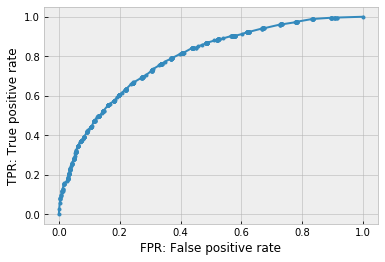

In [41]:
fpr, tpr, thresholds = roc_curve(pred_test_df['is_canceled'],pred_test_df['preds'])
plt.grid(b=True, which='major', linestyle='-')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.plot()
print('log_loss:',log_loss(pred_test_df['is_canceled'],pred_test_df['preds']))
print('auc score:',roc_auc_score(pred_test_df['is_canceled'],pred_test_df['preds']))

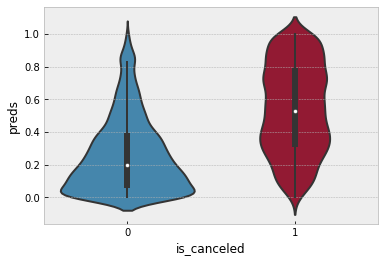

In [42]:
sns.violinplot(pred_test_df['is_canceled'],pred_test_df['preds'])